# Liver Model Construction: Notebook

Made on 23 May 2022

simuulated glycolysis purely with FBA

In [1]:
import os
import re
import warnings
# from cobra.io import *
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)
mass_config = MassConfiguration()
# mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
# from cobra.io.json import *
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [2]:
import sys
# from minspan import minspan,nnz
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [3]:
type(dict)

type

In [4]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")
# extra_dir=os.path.abspath("..")
# minspan_dir

### Getting reactions and metabolite data from RECON 3D

In [5]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"gly_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')


### Loading cobra model

In [6]:
# Initiate empty model
trial= cobra.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-04


In [7]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [8]:
import json

In [9]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"gly_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [10]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

HEX1
PGI
FBP
PFK
FBA
TPI
GAPD
PGK
PGM
ENO
PYK
LDH_L
ATPM


In [11]:
nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
rxn = cobra.Reaction('NADHM')
trial.add_reaction(rxn)
rxn.add_metabolites(nadhm)

In [12]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {'charge': -1.0}
PGI {}
FBP {'charge': 2.0}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
LDH_L {'charge': -1.0}
ATPM {'charge': 1.0}
NADHM {'charge': 1}


In [13]:
trial.metabolites.h_c.charge= 1
# trial.metabolites.h_e.charge= 1
trial.metabolites.pi_c.charge= -2

In [14]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
FBP {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PYK {}
LDH_L {}
ATPM {}
NADHM {'charge': 2}


In [15]:
for met in ['glc__D_c', 'h2o_c', 'h_c', 'pi_c','lac__L_c', "pyr_c"]:
    rxn = cobra.Reaction('EX_%s' % met)
    trial.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # by convention negative exchange flux = uptake
    elif met == 'pyr_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

In [16]:
for reaction in trial.reactions:
    print(reaction)

HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
FBP: fdp_c + h2o_c --> f6p_c + pi_c
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c
PGM: 2pg_c <=> 3pg_c
ENO: 2pg_c <=> h2o_c + pep_c
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c
LDH_L: lac__L_c + nad_c <=> h_c + nadh_c + pyr_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
NADHM: nadh_c --> h_c + nad_c
EX_glc__D_c: glc__D_c <=> 
EX_h2o_c: h2o_c <=> 
EX_h_c: h_c <=> 
EX_pi_c: pi_c <=> 
EX_lac__L_c: lac__L_c <=> 
EX_pyr_c: pyr_c --> 


In [17]:
trial.objective = 'ATPM'
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
HEX1,1.0,0.0
PGI,1.0,0.0
FBP,0.0,-2.0
PFK,1.0,0.0
FBA,1.0,0.0
...,...,...
EX_h2o_c,0.0,-0.0
EX_h_c,2.0,0.0
EX_pi_c,0.0,0.0
EX_lac__L_c,2.0,0.0


In [18]:
trial.metabolites.pi_c.summary()

Percent,Flux,Reaction,Definition
100.00%,2,ATPM,atp_c + h2o_c --> adp_c + h_c + pi_c
Percent,Flux,Reaction,Definition
100.00%,-2,GAPD,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c


In [19]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 1.0, 'PGI': 1.0, 'FBP': 0.0, 'PFK': 1.0, 'FBA': 1.0, 'TPI': 1.0, 'GAPD': 2.0, '…

In [20]:
from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob
from cobra.io import save_json_model



In [21]:

liver_json = os.path.join(model_dir,"gly_json.json")
cobra.io.save_json_model(trial, liver_json )

In [22]:
for model_file in glob(liver_json):
    model_name = model_file.split('/')[-1]
    if 'model' not in model_name:
        continue
    print(model_name)
    model= load_json_cobra_model(model_file)
    if 'NADPHM' in model.reactions:
        model.remove_reactions(['NADPHM'])
    # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
    #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
    #         'EX_etoh_c', 'EX_fru_c']
    media = ['EX_glc__D_c']
    for met in media:
        if met in model.reactions:
            model.reactions.get_by_id(met).lower_bound = -1000.

    rxns = [i.id for i in model.reactions]
    blocked = cobra.flux_analysis.find_blocked_reactions(model)
    print(blocked)
    model.remove_reactions(blocked)

    solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
    df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
    df = df/df.abs().max()
    for col in range(len(df.columns)):
        column=df.iloc[:,col]
        vals = column.values
        min_val = min([abs(i) for i in vals if i != 0])
        corr_fac=1/min_val
        vals=vals*abs(corr_fac)
        df['Norm'+ str(col)]=vals
    csv_dir = os.path.join(minspan_dir,"gly_csv.csv")
    df.to_csv(csv_dir)

c:\Users\sicil\LiverModel\models\gly_json.json
['EX_h2o_c', 'EX_pi_c']
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpabqnuzxh.lp
Reading time = 0.00 seconds
: 19 rows, 36 columns, 116 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp8kfqddo9.lp
Reading time = 0.00 seconds
: 55 rows, 54 columns, 217 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpxpny027v.lp
Reading time = 0.00 seconds
: 55 rows, 54 columns, 217 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp7f2op728.lp
Reading time = 0.00 seconds
: 55 rows, 54 columns, 217 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmps_yekita.lp
Reading time = 0.00 seconds
: 55 rows, 54 columns, 217 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpfp6ybwg5.lp
Reading time = 0.00 seconds
: 55 rows, 54 columns, 217 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\

In [23]:
csv_minspan_dir = os.path.join(minspan_dir,"gly_csv.csv")
minspan_df = pd.read_csv(csv_minspan_dir,index_col=0) 
minspan_df

,0,1,2,Norm0,Norm1,Norm2
HEX1,0.166667,0.0,0.166667,1.0,0.0,1.0
PGI,0.166667,0.0,0.166667,1.0,0.0,1.0
FBP,0.333333,0.0,0.000000,2.0,0.0,0.0
PFK,0.500000,0.0,0.166667,3.0,0.0,1.0
FBA,0.166667,0.0,0.166667,1.0,0.0,1.0
TPI,0.166667,0.0,0.166667,1.0,0.0,1.0
GAPD,0.333333,0.0,0.333333,2.0,0.0,2.0
PGK,-0.333333,0.0,-0.333333,-2.0,0.0,-2.0
PGM,-0.333333,0.0,-0.333333,-2.0,0.0,-2.0
ENO,0.333333,0.0,0.333333,2.0,0.0,2.0


In [24]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [25]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=met_df.append(df_2)

met_df=met_df.set_index('id')

C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\2929221198.py:7 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\2929221198.py:7 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\2929221198.py:7 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\2929221198.py:7 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\2929221198.py:7 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Us

In [26]:
met_df

,name,charge,formula,compartment
id,,,,
adp_c,ADP C10H12N5O10P2,-3,C10H12N5O10P2,c
atp_c,ATP C10H12N5O13P3,-4,C10H12N5O13P3,c
g6p_c,D-Glucose 6-phosphate,-2,C6H11O9P,c
glc__D_c,D-Glucose,0,C6H12O6,c
h_c,H+,1,H,c
f6p_c,D-Fructose 6-phosphate,-2,C6H11O9P,c
fdp_c,"D-Fructose 1,6-bisphosphate",-4,C6H10O12P2,c
h2o_c,H2O H2O,0,H2O,c
pi_c,Phosphate,-2,HO4P,c


In [27]:
csv_met_cobra = os.path.join(data_dir,"gly_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [29]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df=rxn_df.append(df)

rxn_df=rxn_df.set_index('id')

C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\667217370.py:8 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\667217370.py:8 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\667217370.py:8 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\667217370.py:8 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\sicil\AppData\Local\Temp\ipykernel_32980\667217370.py:8 FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\s

In [30]:
rxn_df

,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,objective_coefficient
id,,,,,,
HEX1,Hexokinase (D-glucose:ATP),"{'adp_c': 1.0, 'atp_c': -1.0, 'g6p_c': 1.0, 'g...",0.0,1000.0,,NaN
PGI,Glucose-6-phosphate isomerase,"{'f6p_c': 1.0, 'g6p_c': -1.0}",-1000.0,1000.0,,NaN
FBP,Fructose-bisphosphatase,"{'f6p_c': 1.0, 'fdp_c': -1.0, 'h2o_c': -1.0, '...",0.0,1000.0,,NaN
PFK,Phosphofructokinase,"{'adp_c': 1.0, 'atp_c': -1.0, 'f6p_c': -1.0, '...",0.0,1000.0,,NaN
FBA,Fructose-bisphosphate aldolase,"{'dhap_c': 1.0, 'fdp_c': -1.0, 'g3p_c': 1.0}",-1000.0,1000.0,,NaN
TPI,Triose-phosphate isomerase,"{'dhap_c': -1.0, 'g3p_c': 1.0}",-1000.0,1000.0,,NaN
GAPD,Glyceraldehyde-3-phosphate dehydrogenase,"{'13dpg_c': 1.0, 'g3p_c': -1.0, 'h_c': 1.0, 'n...",-1000.0,1000.0,,NaN
PGK,Phosphoglycerate kinase,"{'13dpg_c': 1.0, '3pg_c': -1.0, 'adp_c': 1.0, ...",-1000.0,1000.0,,NaN
PGM,Phosphoglycerate mutase,"{'2pg_c': -1.0, '3pg_c': 1.0}",-1000.0,1000.0,,NaN


In [31]:
json_rxn_cobra = os.path.join(data_dir,"gly_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra
,orient="index")

In [32]:
csv_met_cobra = os.path.join(data_dir,"gly_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [33]:
json_rxn_cobra = os.path.join(data_dir,"gly_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra,orient="index")

## Making MASS model of glycolysis

In [82]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model

In [83]:
# making dataframe of metabolites
import json
met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

In [84]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [85]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
#     if reaction_obj.id != "DM_nadh" or reaction_obj.id != 'ATPM':
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [86]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
# liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x01b737c4d3a0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


## Setting initial conditions

In [87]:
import csv
import openpyxl

In [88]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [100]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations2.xlsx")
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)

In [101]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)

In [102]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            # print(mid)
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            # print(mid,ic_value)
            # row = [mid,ic_value]
            # column = [ic_value]
            met.ic =  (ic_value)            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
pi_c: 0.0064
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
13dpg_c: 2.43e-07
nad_c: 0.00182530972
nadh_c: 4.63542e-06
3pg_c: 0.000520630485
2pg_c: 0.000110560855
pep_c: 0.00031
pyr_c: 0.00047999999999999996
lac__L_c: 0.00326183772


### Getting Standard and Physiological Gibbs energies of reactions

In [92]:
reaction_str= []

cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp as exp


In [93]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions

excluded_reactions=["ATPM", 
"NADHM",
]

In [94]:
print("Boundary Reactions and Values\n-----------------------------")
for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

# Trying to set these as 1e6 becasue the inf might be messing with the solver
liver.reactions.ATPM.Keq=1e6
liver.reactions.NADHM.Keq=1e6

Boundary Reactions and Values
-----------------------------
EX_glc__D_c: glc__D_c <=> 
glc__D_b: 0.01048280703

EX_pi_c: pi_c <=> 
pi_b: 0.0064

EX_lac__L_c: lac__L_c <=> 
lac__L_b: 0.00326183772

EX_pyr_c: pyr_c <=> 
pyr_b: 0.00047999999999999996



In [95]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")    

HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
FBP
Keq = 115004.76795942851
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PYK
Keq = 10333.2896179346
LDH_L
Keq = 0.00013815091719569572


##  Set Fluxes

In [96]:
reaction_list=[]
for reaction in trial.reactions:
    r_id = reaction.id
    reaction_list.append(r_id)
reaction_list

['HEX1',
 'PGI',
 'FBP',
 'PFK',
 'FBA',
 'TPI',
 'GAPD',
 'PGK',
 'PGM',
 'ENO',
 'PYK',
 'LDH_L',
 'ATPM',
 'NADHM',
 'EX_glc__D_c',
 'EX_h2o_c',
 'EX_h_c',
 'EX_pi_c',
 'EX_lac__L_c',
 'EX_pyr_c']

In [97]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux
    #  * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 1.0
v_PGI: 1.0
v_FBP: 0.0
v_PFK: 1.0
v_FBA: 1.0
v_TPI: 1.0
v_GAPD: 2.0
v_PGK: -2.0
v_PGM: -2.0
v_ENO: 2.0
v_PYK: 2.0
v_LDH_L: -2.0
v_ATPM: 2.0
v_NADHM: 0.0
v_EX_glc__D_c: -1.0
v_EX_h2o_c: 0.0
v_EX_h_c: 2.0
v_EX_pi_c: 0.0
v_EX_lac__L_c: 2.0
v_EX_pyr_c: 0.0


In [98]:
liver.metabolites.h_c.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2

## Setting initial conditions

In [103]:
# import csv
# csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.csv")
# # opening the CSV file
# with open(csv_ic, mode ='r')as file:
   
#   # reading the CSV file
#     csvFile = csv.reader(file)

#       # displaying the contents of the CSV file
#     for name, value in csvFile:
#         met_id = liver.metabolites.get_by_id(name)
#         met_id.ic = float(value) #M
#         print(met_id, ":", met_id.ic)
        # print(name,value)

## Set H2O/H Constants

In [104]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [105]:
for metabolite in [
#     'h_m',
"h_c", 
#     'h_e',
"h2o_c",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [106]:
for metabolite in liver.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
h2o_c: 1
pi_c: 0.0064
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
13dpg_c: 2.43e-07
nad_c: 0.00182530972
nadh_c: 4.63542e-06
3pg_c: 0.000520630485
2pg_c: 0.000110560855
pep_c: 0.00031
pyr_c: 0.00047999999999999996
lac__L_c: 0.00326183772


In [107]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",
#     "pi_e",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
#     excluded_reactions=["Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
#     'L_LACt2r','PYRt2'],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['FBP', 'NADHM']
['FBP', 'NADHM']
mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,variables,reduced_costs
adp_c,0.001995,0.0
atp_c,0.004727,0.0
g6p_c,0.000269,0.0
glc__D_c,0.010483,0.0
f6p_c,0.000066,0.0
...,...,...
Keq_PGM,0.137497,0.0
Keq_ENO,4.850113,0.0
Keq_PYK,10333.289618,0.0
Keq_LDH_L,0.000093,0.0


In [108]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [109]:
#Compare Results
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info = load_data(
    filepath=csv_ic,
    sheet_name="Concentrations")

mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'_3pg_c', '_2pg_c'}, only in one set of given values


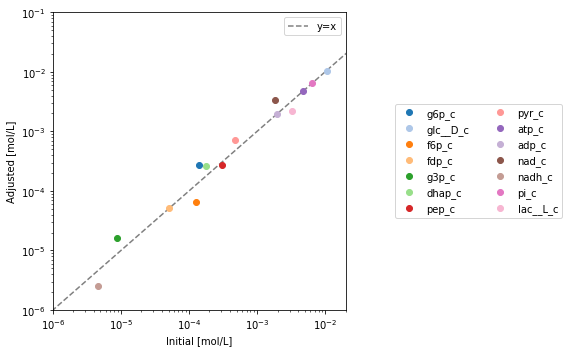

In [110]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=ic_info["Concentrations in M"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in ic_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [111]:
liver.reactions.EX_glc__D_c.Keq = 1
liver.reactions.EX_h_c.Keq = 1 
liver.reactions.EX_h2o_c.Keq = 1 
liver.reactions.EX_pi_c.Keq = 1 
liver.reactions.EX_pyr_c.Keq = 1 
liver.reactions.EX_lac__L_c.Keq = 1 
# liver.reactions.EX_nadh_c.Keq = 1 
# liver.reactions.EX_nad_c.Keq = 1 

In [112]:
liver.boundary_conditions['glc__D_b']=0.010482807 ##M ## initial condition of the metabolite in the model
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=0.0064 ##M
liver.boundary_conditions['pi_b']=0.010482807 ##M
liver.boundary_conditions['pyr_b']=0.00048 ##M
liver.boundary_conditions['nadh_b']=4.63542E-06
liver.boundary_conditions['nad_b']=0.00182531
liver.boundary_conditions['lac__L_b']=0.003261838

In [113]:
Boundary= [
             "EX_glc__D_c", 
            "EX_h_c", 
            "EX_h2o_c",
            'EX_pyr_c',
            'EX_pi_c',
    "ATPM",
    
#     'EX_nad_c',
    "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [114]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
#                         or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
#                                 r== glycogenolysis.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
#                                 r== glycogenolysis.reactions.PEPtm or r== glycogenolysis.reactions.GLCt1 
#                                 or r== glycogenolysis.reactions.Ht
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 20180.147815
kf_PGI: 5880.895178
kf_FBP: 100000.000000
kf_PFK: 3197815.633941
kf_FBA: 19438.290251
kf_TPI: 6058.637674
kf_GAPD: 9253739259.784975
kf_PGK: 2406960633.919394
kf_PGM: 2803.162880
kf_ENO: 20387.128905
kf_PYK: 3622627.083437
kf_LDH_L: 160492.127493
kf_ATPM: 423.088268
kf_NADHM: 100000.000000
kf_EX_glc__D_c: 1000000.000000
kf_EX_h2o_c: 1000000.000000
kf_EX_h_c: 1000000.000000
kf_EX_pi_c: 1000000.000000
kf_EX_lac__L_c: 1000000.000000
kf_EX_pyr_c: 1000000.000000


In [115]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [116]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [117]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: Core_Model                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ --------------------                         │
│ NADHM: {charge: 2.0}                         │
│ ============================================ │
╘══════════════════════════════════════════════╛


Successfully loaded MassModel 'Core_Model' into RoadRunner.


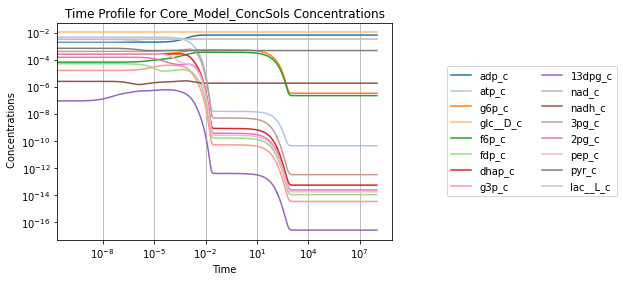

In [118]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
json_save = os.path.join(model_dir,liver.id + ".json")
json.save_json_model(model=liver, filename=json_save)